# NYISO Hourly Load Forecast

Name: Orlando Vilar
Date: 5/2023

In this project, I provide the test of several models in forecasting hourly electricity load in New York City. Using data from the New York Independent System Operator (NYISO), I apply several time series analysis techniques and provide forecasting model frameworks and their results. 

<ul>
<li><b>Stakeholder</b>: The NY Independent System Operator;</li>
<li><b>Business Problem</b>: diminishing the risk of load mismatching, and its associated costs;</li>
<li><b>Proposal</b>: three time series frameworks.</li>
</ul>


### Business Understanding
Independent System Operators are entities that coordinate the electric grid in order to provide a well-functioning system with reliability. One can imagine the significant social and economic costs of such systems malfunction. As a whole, the system involves the participation of generators, transmission and utility companies - and the general public.

The proper operation of the system is a complete task, that has several steps. Focusing on one of its several activities, I provide a simplified study using forecasting tools in order to check whether they are reliable methodologies to forecast the system's load. Suppose - once again over a simplified scenario - that forecasting problems could lead to black-outs. 

The estimate cost of a blackout in New York City alone is around <a href = 'https://www.cnn.com/2019/07/14/us/new-york-city-power-outage-42-years-trnd/index.html' alt = 'CNN - New York City Power Outage'>$350 million</a>.  Even though forecasting per se isn't the reason for black-outs (most of the time), it can set some bounds to the cost of a system malfunction. The business problem can be stated as diminishing the risk of load mismatching aiming for an operation without hiccups.


## Basic Libraries and Functions
I start by importing the libraries that are going to be used. After that, I build a set of functions that will execute tasks on the DataFrames that are going to be analyzed. The aim of these functions is to streamline the procedures that are going to be performed on the dataset.

In [1]:

import keras
import requests
import numpy as np
import pandas as pd
# import logging
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import tensorflow as tf
from prophet import Prophet
import statsmodels.api as sm
from keras import backend as K
import matplotlib.pyplot as plt
from keras.models import Sequential
from scipy.stats import randint, uniform
from statsmodels.tsa.stattools import adfuller
from keras.optimizers import Adam, RMSprop, SGD
from sklearn.preprocessing import StandardScaler
from keras.layers import Conv1D, Dense, Dropout, LSTM
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import make_scorer, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [2]:
# Setting seed
np.random.seed(42)
tf.random.set_seed(42)

# Defining the support functions
def mape(y_true, y_hat):

    '''This function calculates the Mean Absolute Percentage Error and takes as input the true Y values (y_true) and the predicted Y
    values (y_hat)'''

    return np.mean(np.abs((y_true - y_hat) / y_true)) * 100

def mean_absolute_percent_error(y_true, y_pred):
    '''This function calculates the Mean Absolute Percentage Error and takes as input the true Y values (y_true) and the predicted Y
    values (y_hat) - however, to be used with keras'''
    
    return K.mean(K.abs((y_true - y_pred) / y_true)) * 100


# Defining a function for ACF and PACF plots - inspired by Flatiron School's Time Series Lab
def func_plot(dataframe):
    
    '''This function will plot the autocorrelation and partial autocorrelation plots from a DataFrame.'''
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20,8))
    plot_acf(dataframe, ax = ax1, lags = 120)
    plot_pacf(dataframe, ax = ax2, lags = 120)
    plt.show();


def sarimax(df, exog = None, pdq = (0,0,0), pdqs = (0,0,0,0), train_test = 'train', window = 24):
    
    '''This function calculates the Mean Absolute Percent Error for train (default) or \
    testing data, taking as input the dataframe, the pdq and pdqs factors (order and seasonal order) \
    an argument (i.e whether 'test' or 'train') and a default window of 24 periods. Its outputs are \
    the summary diagnostic for the SARIMAX model, with plots and the MAPE.
    '''
    
    # If 'train' or else
    if train_test == 'train':
        train = df['Load'].dropna()
        exog_var = exog.reindex(train.index)
        model = SARIMAX(train, order = pdq, seasonal_order = pdqs, exog = exog_var)
        output = model.fit()
        y_hat = output.predict(-window)
        print(output.summary())
        output.plot_diagnostics(figsize=(10,5))
        plt.tight_layout()
       
    else:
        test = df['Load'].dropna()
        exog_var = exog.reindex(test.index)
        model = SARIMAX(test, order = pdq, seasonal_order = pdqs, exog = exog_var)
        output = model.fit()
        y_hat = output.predict(-window)
        print(output.summary())
        output.plot_diagnostics(figsize = (10,5))
        plt.tight_layout()
        

def forecast_ci(df, exog=None, pdq=(0,0,0), pdqs=(0,0,0,0)):
  
    '''This function takes as input a dataframe, exogenous variables, and the order and seasonal order factors
    and retrieves the mean predicted values for a horizon with confidence intervals around 0.1-0.9.
    '''
    df = df.reset_index().set_index('Time Stamp')
    if exog is not None:
        exog = exog.reset_index().set_index('Time Stamp')
        model = SARIMAX(df, exog = exog, order = pdq, seasonal_order = pdqs)
    else:
        model = SARIMAX(df, order = pdq, seasonal_order = pdqs)

    output = model.fit()

    if exog is not None:
        pred = output.get_prediction(start = df.index[0], end = df.index[-1],
                                     dynamic = True, exog = exog)
    else:
        pred = output.get_prediction(start=df.index[0], end = df.index[-1],
                                     dynamic=True)

    pred_summary = pred.summary_frame(alpha=0.1)
    y_true = df['Load']
    

    fig, ax = plt.subplots(figsize=(15, 8))

    pred_summary['mean'].plot(ax = ax, label = 'Forecasted Value')
    ax.fill_between(pred_summary.index, pred_summary['mean_ci_lower'], pred_summary['mean_ci_upper'],
                        color = 'r', alpha = .2, label='Confidence Interval')
    y_true.plot(ax = ax, label = 'Actual Value')
    plt.title('Forecast of Hourly Load')
    plt.xlabel('Date')
    plt.legend()
    plt.show()


def create_model(optimizer = 'adam', neurons = 256, dropout = 0.2, epochs = 100, batch_size = 30, learning_rate = 0.01):
  '''This function will create a basic model so we can run a Randomized Grid Search on it.'''
  if optimizer == 'adam':
    opt = Adam(lr = learning_rate)
  elif optimizer == 'rmsprop':
    opt = RMSprop(lr = learning_rate)
    model.compile(loss='mae', optimizer = opt)
  else:
    opt = SGD(lr = learning_rate)
    model.compile(loss = 'mae', optimzer = opt)

  model = Sequential()
  model.add(LSTM(neurons, input_shape = (X_train_keras.shape[1], X_train_keras.shape[2])))
  model.add(Dropout(dropout))
  model.add(Dense(1))
  model.compile(loss='mae', optimizer=optimizer)
    
  return model


## Data Wrangling and Basic Analysis
### Merging Real-Time (RT) data and Weather daily files
The next step is to merge all the Real-Time and Weather daily files into a database each. Then, those will be merged into one big dataset so we can use for our time series analysis procedure.

Please note that I'm referencing the .csv files from the repository. In order to download those, I ran a script to download them directly from the NYISO website. After that, I filtered the csv accordingly to the tasks that I'm going to develop further.

You can contact me if you need or would like to check the code that I've used. The following <a href='http://mis.nyiso.com/public/P-58Blist.htm' alt = 'Real-Time Data'>link1</a> and <a href='http://mis.nyiso.com/public/P-7Alist.htm'>link2</a> are the main source that I scraped the files from.

In [3]:
# Merging the Real-Time and Weather files
df_rt = pd.read_csv('https://raw.githubusercontent.com/ovilar/phase_5-project/main/csv/rt_data.csv')
df_wx = pd.read_csv('https://raw.githubusercontent.com/ovilar/phase_5-project/main/csv/weather_data.csv')

# Formatting TimeStamp
df_rt['Time Stamp'] = pd.to_datetime(df_rt['Time Stamp'], format = '%Y-%m-%d %H:%M:%S')

# Forecast and Vintage Date formatting
df_wx['Forecast Date'] = pd.to_datetime(df_wx['Forecast Date'], format = '%Y-%m-%d')
df_wx['Vintage Date'] = pd.to_datetime(df_wx['Vintage Date'], format = '%Y-%m-%d')


### Graphical analysis
I plot then the Hourly Load per Zone, within the NYISO area. We can note there's an issue with the data from Apr/2017. Unfortunately, the file that is made available on the NYISO website only lists 6 days (25th-30th). We can also spot check that the same month in 2021 has missing data, which is an issue that we cannot circumvent without eliminating those data points.

Nonetheless, through an overall inspection we can see that NYC is the region with most load flowing through the system, followed by Long Island and the Capital regions. For the sake of time constraints, I will focus only in the NYC area (Zone J). If you want to know more, each location is bucketed into zones and these can be found <a href = 'https://www.nyiso.com/documents/20142/1397960/nyca_zonemaps.pdf/8c3807e1-5bab-ab44-3c71-2c8e61b5748b' alt = 'NYISO New York Control Area Zone Maps'>here</a>.  

On an overall inspection, we can see that winter time has more load than the rest of the year, followed by summertime. For the forecasting exercise I'll limit the sample from January 2018 to December 2020 - so we avoid any missing data from our estimates.

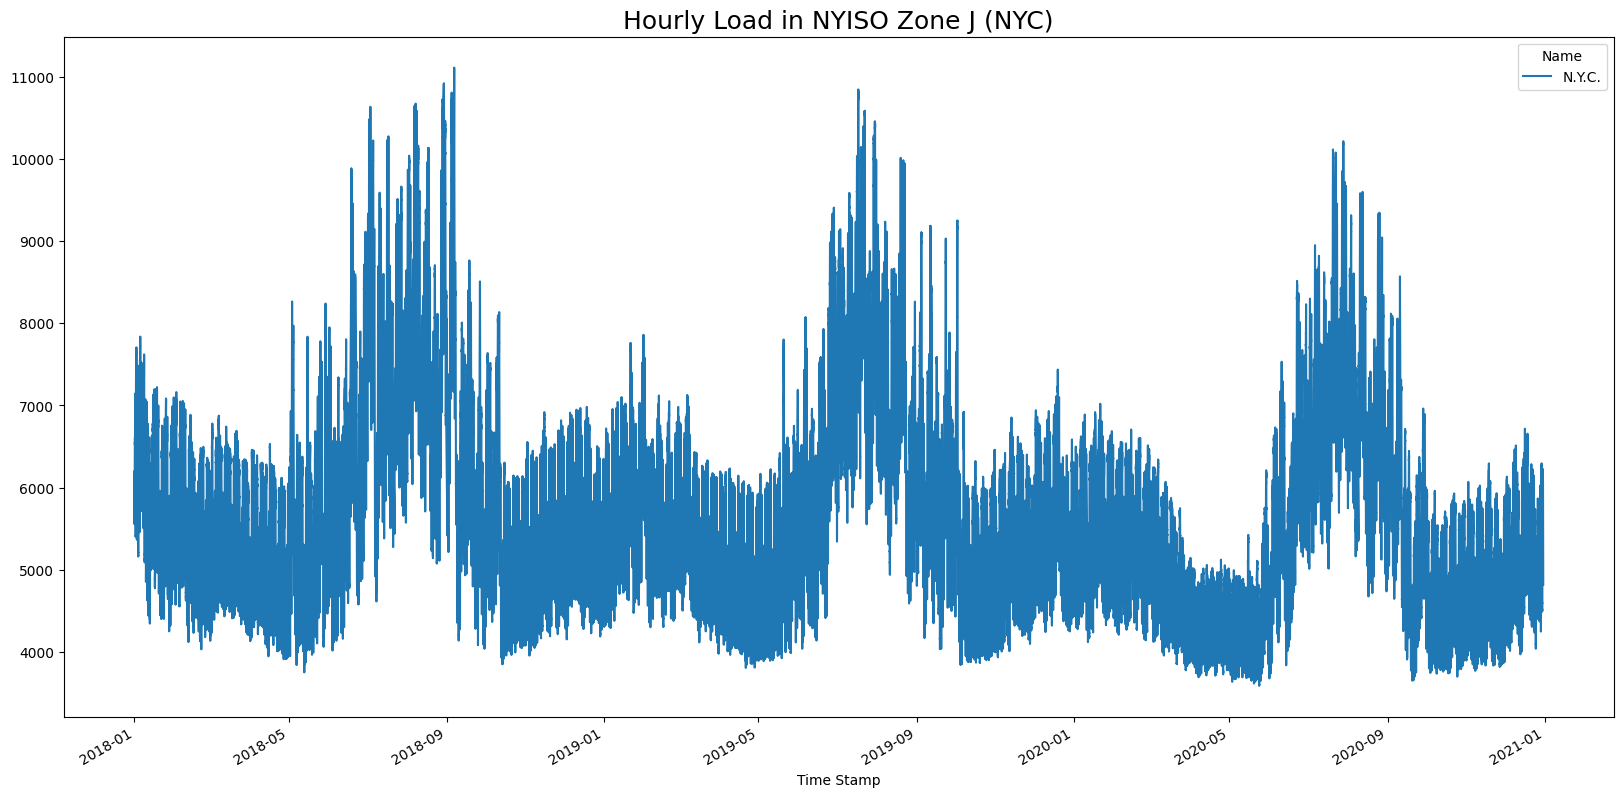

In [4]:
# Generating a Pivot Table to plot the Graph
table = pd.pivot_table(df_rt, values = 'Load', index = ['Time Stamp'], columns = ['Name'])

# Configuring and Plotting the table
fig, ax = plt.subplots(figsize = (20, 10))
table.plot(ax = ax)
ax.set_title('Hourly Load in NYISO Zone J (NYC)', fontsize = 18)
ax.set_xlabel('Time Stamp')
plt.show();


### Working with weather data
Now, I'll start working with weather data. We have several locations that are identified as Station IDs. For the New York City, the process os evaluating the weather station is a weighted average between the IDs (in parenthesis) pertaining to Central Park (NYC), LaGuardia (LGA) and the JFK Airports (JFK). The process of generating the Climate Temperature and Humidity Index (CTHI) can be found <a href='https://www.nyiso.com/documents/20142/20053386/LFU_Whitepaper_Phase1_Results.pdf/40ce5384-d790-b3f5-cc55-270b39ab23fe' alt = 'NYISO Climate Temperature and Humidity Index (CTHI) methodology'>here</a>.

Due to data availability issues, I calculate a proxy for this measurement. Also, since I don't have temperature data available at the hourly frequency - these estimates are less precise than the ideal ones. I use a simple resample procedure so we can have the 24 hour time, however this is far from perfect. We can then merge both DataFrames with respect to their dates so we can start working on the load estimates.

Lastly, I calculate then the cooling day degree (CDD) and the heating day degree (HDD). These are well established statistics that try to capture load dynamics with respect to a baseline level of 65 degrees. This statistic is far from perfect, since it misses to capture non-linear relationships, however it is an increment to the CTHI one we calculated above.

In [5]:
# Now creating a new DataFrame, we filter for JFK, LGA and NYC
df2 = df_wx[(df_wx['Station ID'] == 'JFK') | (df_wx['Station ID'] == 'LGA') | (df_wx['Station ID'] == 'NYC')]

# Next, filtering for the same time frame as the RT dataframe
df2 = df2[(df2['Forecast Date'] >= '01/01/2018') & (df2['Vintage Date'] <= '12/31/2020')]

# Creating a proxy weighted average THI
df2['THI'] = 0.8 * df2['Max Wet Bulb'] + 0.2 * df2['Min Wet Bulb']

# Groupby Vintage Date and filtering columns
df_weather = df2.groupby(pd.Grouper(key = 'Vintage Date', freq = 'D')).max()
df_weather = df_weather.loc[:, ['Forecast Date', 'Max Temp', 'Min Temp', 'THI']]

# Creating a proxy CTHI
df_weather['CTHI'] = 0.7 * df_weather['THI'] + 0.2 * df_weather['THI'][1] + 0.1 * df_weather['THI'][2]

# Creating CDD/HDD
df_weather['CDD'] = (df_weather['Max Temp'] + df_weather['Min Temp']) / 2 - 65
df_weather['HDD'] = 65 - (df_weather['Max Temp'] + df_weather['Min Temp']) / 2 

# Substituting negative values
df_weather.loc[df_weather['CDD'] < 0, 'CDD'] = 0
df_weather.loc[df_weather['HDD'] < 0, 'HDD'] = 0

# Resetting Index and Grouping with averages
df_weather.reset_index(inplace = True)
df_weather = df_weather.groupby(pd.Grouper(key = 'Vintage Date', freq = 'D')).mean()

# Merging the two datasets (real-time and weather), filtering and filling NAs
df_weather.reset_index(inplace = True)
df_weather.rename({'Vintage Date': 'Time Stamp'}, axis = 1 , inplace = True)
data = pd.merge(df_rt, df_weather, on = 'Time Stamp', how = 'left') 
data = data.loc[:,['Time Stamp', 'Load', 'CTHI', 'CDD' , 'HDD']]
data = data.fillna(method = 'ffill')


### Plotting the adjusted data
With all the adjustments in place, after calculating the weather statistics and merging the datasets I then plot the Hourly Load and the CTHI statistic. We can visually inspect how they almost perfectly overlap, which gives us an idea that weather must have a strong correlation with load usage. The attentive reader might question why then I am not plotting the CDD and HDD statistics as well. Since these are 'stepwise' calculation - i.e. they are the maximum value between a threshold (65 Farehnheit degrees) and 0 - it doesn't make too much sense to plot it on top of load. However, this doesn't rule out its use later during our model estimations.

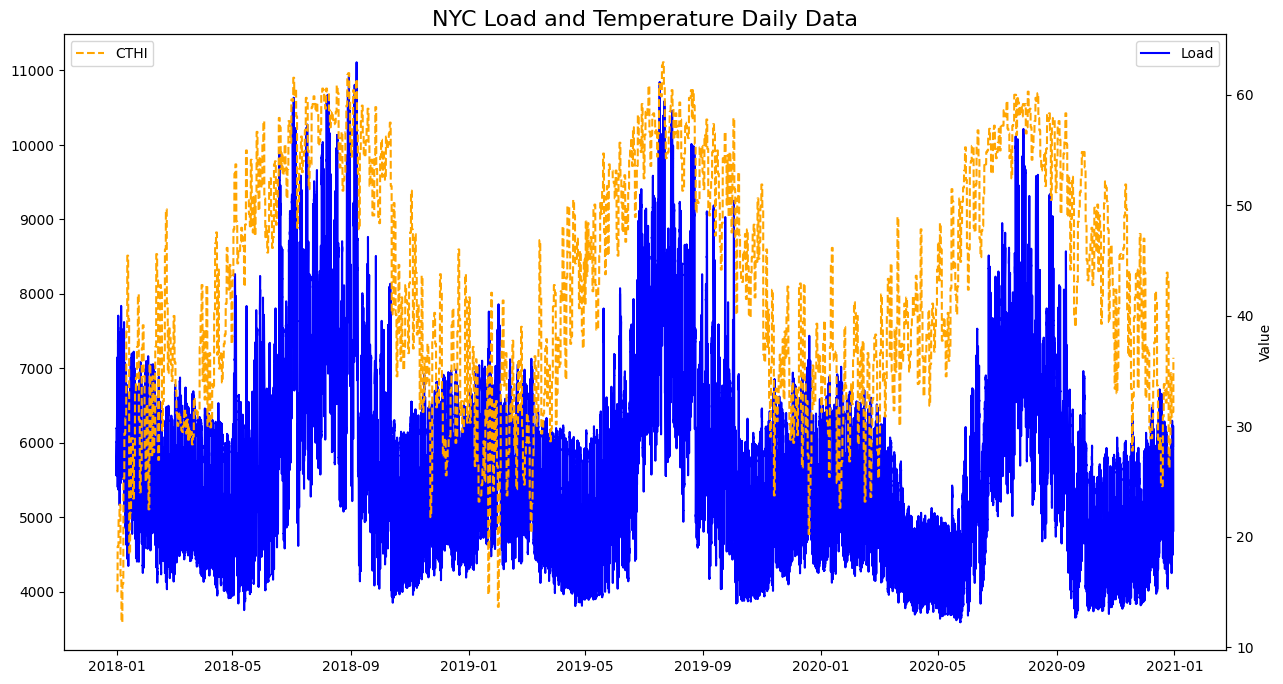

In [6]:
# Zone J Plot - Load, CTHI, CDD and HDD avs
fig, ax1 = plt.subplots(figsize = (15, 8))
ax2 = ax1.twinx()

ax1.plot(data['Time Stamp'], data['Load'], label = 'Load', color = 'blue')
ax2.plot(data['Time Stamp'], data['CTHI'], label = 'CTHI', color = 'orange', linestyle = 'dashed')

# Set the axis labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('NYC Load and Temperature Daily Data', fontsize = 16)

# Add legend and show
ax1.legend(['Load'], loc = 'upper right')
ax2.legend(['CTHI'], loc = 'upper left')
plt.show();

### How about the holidays?
The last dataset adjustment is with respect to holidays. The load usage during peak days (i.e. 8 AM - 12 AM during business days) is different than off-peak days (the hours between 8 AM to 12 AM in weekends and holidays). Thus, I make this adjustment to our dataset by creating Holiday or Off-Peak days accordingly. 

This will be later used as an exogenous variable in our forecasting exercise.

In [7]:
# Holiday Calendar - NERC holidays
holiday_dict = {
    '2018-01-01': 1, '2018-05-28': 1, '2018-07-04': 1, '2018-09-03': 1 , '2018-11-22': 1, '2018-12-25': 1,
    '2019-01-01': 1, '2019-05-27': 1, '2019-07-04': 1, '2019-09-02': 1, '2019-11-28': 1, '2019-12-25': 1,
    '2020-01-01': 1, '2020-05-25': 1, '2020-07-05': 1, '2020-09-07': 1, '2020-11-26': 1, '2020-12-25': 1            
}

# Creating Holiday Column and mapping it
data['Holiday'] =  data['Time Stamp'].dt.strftime('%Y-%m-%d').map(holiday_dict)
data.loc[data['Holiday'].isna() == True, 'Holiday'] = 0

# Creating Off-Peak (OPK) and Peak Days
data['OPK'] = data['Time Stamp'].apply(lambda x: 1 if x.weekday() in [5, 6] else 0)
data.loc[data['Holiday'] == 1, 'OPK'] = 1
data.loc[(data['OPK'] != 1) | (data['Holiday'] != 1), 'Peak'] = 1
data.loc[(data['OPK'] == 1) | (data['Holiday'] == 1) , 'Peak' ] = 0

# Creating month and year dummies
data['month'] = data['Time Stamp'].dt.month
data['year'] = data['Time Stamp'].dt.year

# Encoding the dummy variables
month_dummy = pd.get_dummies(data['month'], prefix = 'month_')
year_dummy = pd.get_dummies(data['year'], prefix = 'year_')

# Concatenating with the DataFrame
data = pd.concat([data, month_dummy, year_dummy], axis = 1)
data = data.drop(['month', 'year'], axis = 1)


Next, I provide the description of the basic variables and the information of our dataset. There are no null values and 319,938 hourly observations from 2018 through 2020. With the exception of our target variable 'Load', the CTHI, CDD/HDD, all other ones are categorical variables.

In [8]:
# Describing the dataset
data[['Load', 'CTHI', 'CDD', 'HDD', 'Holiday', 'OPK', 'Peak']].describe()

,Load,CTHI,CDD,HDD,Holiday,OPK,Peak
count,319938.000000,319938.000000,319938.000000,319938.000000,319938.000000,319938.000000,319938.000000
mean,5840.514174,43.510739,4.745893,10.954999,0.016359,0.299402,0.700598
std,1262.988598,10.783212,7.025859,12.202577,0.126854,0.457997,0.457997
min,3589.200000,12.260000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4884.000000,34.800000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5723.300000,43.760000,0.000000,6.000000,0.000000,0.000000,1.000000
75%,6458.300000,53.560000,9.500000,20.500000,0.000000,1.000000,1.000000
max,11110.300000,62.940000,28.000000,54.000000,1.000000,1.000000,1.000000


In [9]:
# Checking the variables for nulls and their datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319938 entries, 0 to 319937
Data columns (total 23 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Time Stamp  319938 non-null  datetime64[ns]
 1   Load        319938 non-null  float64       
 2   CTHI        319938 non-null  float64       
 3   CDD         319938 non-null  float64       
 4   HDD         319938 non-null  float64       
 5   Holiday     319938 non-null  float64       
 6   OPK         319938 non-null  int64         
 7   Peak        319938 non-null  float64       
 8   month__1    319938 non-null  uint8         
 9   month__2    319938 non-null  uint8         
 10  month__3    319938 non-null  uint8         
 11  month__4    319938 non-null  uint8         
 12  month__5    319938 non-null  uint8         
 13  month__6    319938 non-null  uint8         
 14  month__7    319938 non-null  uint8         
 15  month__8    319938 non-null  uint8         
 16  mo

### Box-Plot Analysis

#### Days of the Week
Breaking down the analysis to the days of the week and months of the year, we can see some patterns that are well-documented about load forecasting. The days of the week can be further separated into hourly buckets that will be deemed as peak and off-peak. Over a simplified example, we can see there's more load centered around the days of the week than the weekends. Also the plots show the amplitude within the days, which illustrates the example above of peak and off-peak hours on an intraday fashion. The interquartile range across days is close to 2,000 MW during weekdays and around less than a 1,000 MW during weekends. 

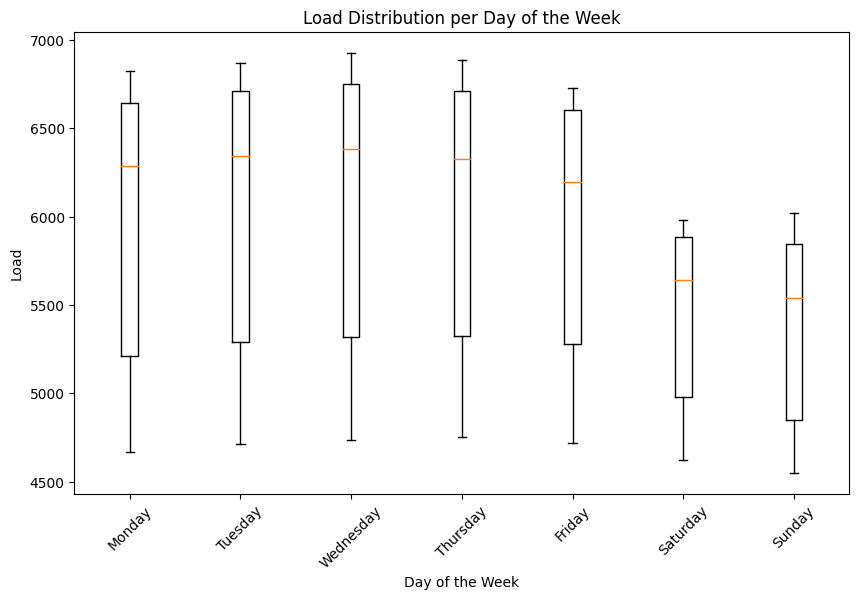

In [10]:
# Setting up information for a box plot
data['day'] = data['Time Stamp'].dt.day_name()
data['month'] = data['Time Stamp'].dt.month
data['year'] = data['Time Stamp'].dt.year

# Grouping by Day
daily_group = data.groupby(['day', data['Time Stamp'].dt.hour])['Load'].mean()

# Daily plot
fig, ax = plt.subplots(figsize = (10, 6))
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for day in days:
    ax.boxplot(daily_group[day].values, positions = [days.index(day)])
ax.set_xticklabels(days, rotation = 45)
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Load')
plt.title('Load Distribution per Day of the Week')
plt.show()



#### Months of the Year
Looking at the months of the year, we see more variation throughout the year. The months associated with higher load are the months of June through September - or centered around the beginning and end of Summer. Around the summer period, we see a decrease to load (January through April, whereas in May it starts increasing) and more stable load from October through December.

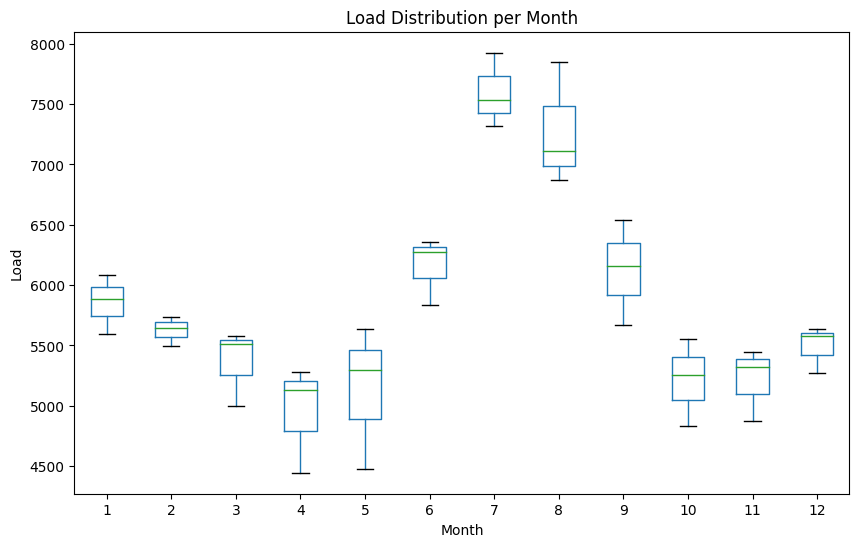

In [11]:
# Create a pivot table with the mean load for each month and year
pivot_table = data.pivot_table(values='Load', index=['year'], columns = 'month', aggfunc='mean')

# Create a boxplot of the load for each month
fig, ax = plt.subplots(figsize=(10, 6))
pivot_table.boxplot(ax=ax, grid=False)
ax.set_xlabel('Month')
ax.set_ylabel('Load')
plt.title('Load Distribution per Month')
plt.show()

# Dropping auxiliar variables
data = data.drop(['day', 'month', 'year'], axis = 1)

## Baseline modeling
I start with a baseline SARIMAX model. In order to run all processes, I reduce the sample size by 30%. After that, I create a Train-Test split so we can validate our models.

### Train-Test Split
On a Time Series approach, the train-test sets cannot be randomly assigned - since that will fail to capture time-varying dynamics. As such, I use the regular 75-25% split (train-test).


In [12]:
# First I reduce the sample size, then I set up training and test data - with split sizes of 75-25
sample_size = (len(data) - 1) * 0.3
split_size = 0.25
train = data.iloc[:int(round(sample_size * (1 - split_size), 0))]
test = data.iloc[-int(round(sample_size * split_size, 0)):]

### Seasonal Decomposition
Since most likely the data has a seasonal component, I run a seasonal decomposition using 8,760 periods (which is the number of hours in an year). This step is necessary before checking stationarity.

Analyzing the decomposition plot, the series seem fairly stationary, we can see a growing trend toward the end of the series and the residuals seem to be hovering around zero - which might indicate normality. Then, the next step is checking whether the Load series are stationary after the seasonal decomposition.

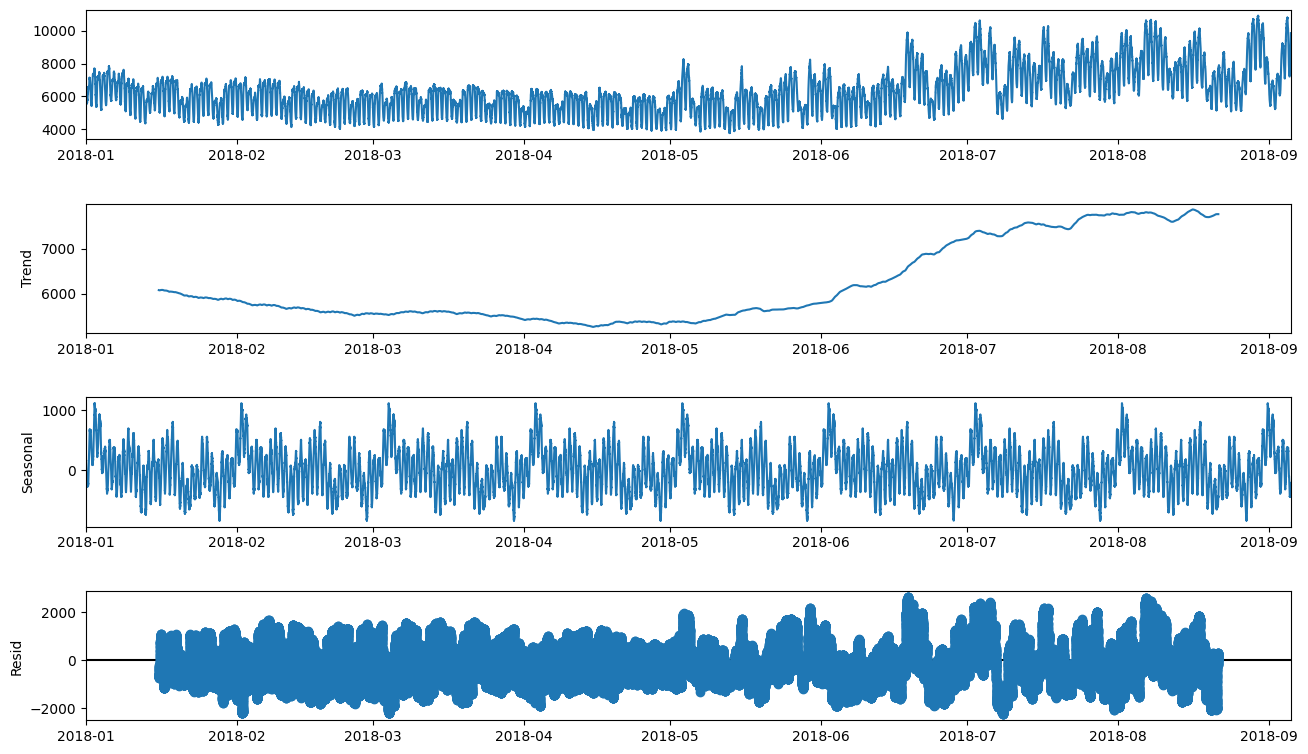

In [13]:
# Decompose the time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(train[['Time Stamp', 'Load']].set_index('Time Stamp'), model = 'additive', period = 8760)

# Plot the decomposed components
fig = decomposition.plot()
fig.set_size_inches((15, 8))
plt.show();




### The ADF test - series stationarity
 Before setting up a baseline model, I check whether the Load series are stationary after the seasonal decomposition. To do so, I run an Augmented Dickey-Fuller test that has as its null series non-stationarity and as the alternative series are stationary. I use a p-value of 5% (0.05) as the test's significance level. We reject the null hypothesis - then we can infer the series are stationary. However, we need to account for the seasonality effect.

In [14]:
# Running the Augmented Dickey-Fuller (ADF) test and checking the series stationarity
# We reject the null, thus the series are stationary

adftest = adfuller(decomposition.seasonal)
print('ADF test:')
print('======================')
print('p-value: ', round(adftest[1],4))
if adftest[1] >= 0.05:
        print('-Fail to reject H0.\n')
            
else:
        print('-H0 is rejected.\n')

ADF test:
p-value:  0.0
-H0 is rejected.



### Differencing to remove seasonality
In the next step, I apply the first difference to the load series to remove the seasonality. We can inspect that after the procedure the series become fairly stationary, hovering around 0. I also plot the rolling mean and standard deviation. By inspecting the rolling mean, we still see some seasonality patterns. Right below, I plot the autocorrelation and partial autocorrelation and it is clear there are several autoregressive and moving average components.

Since this is my baseline model, and it takes a long time to run a model with several lags, I will use a parcimonious approach with p and q being set to 1.

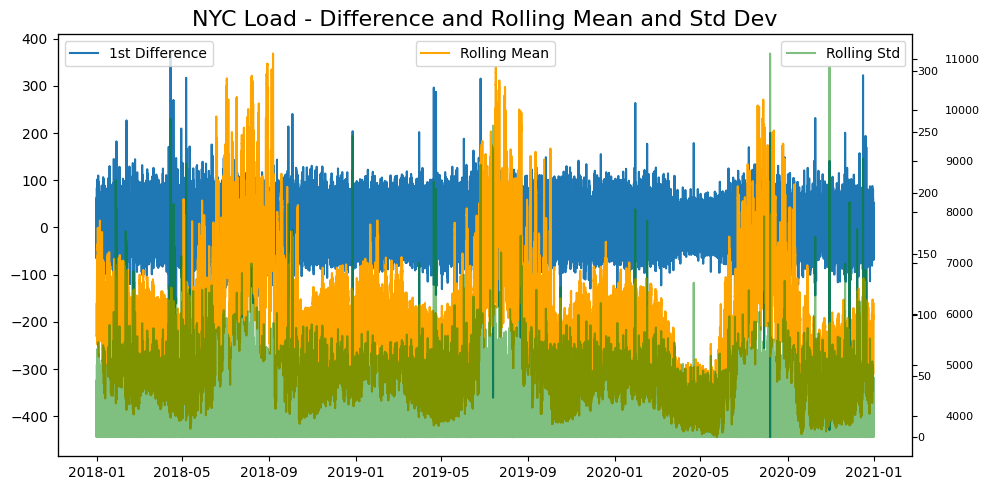

In [15]:
# Creating the series to be plotted
data['Shift 1'] = data['Load'].diff(1).dropna()
data['Mean 1'] = data['Load'].rolling(window = 2, center = False).mean().dropna()
data['Std Dev 1'] = data['Load'].rolling(window = 2, center = False).std().dropna()

# Creating Plots
fig, ax1 = plt.subplots(figsize = (10, 5))
ax2 = ax1.twinx()
ax3 = ax1.twinx()

ax1.plot(data['Time Stamp'], data['Shift 1'], label = 'First Difference')
ax2.plot(data['Time Stamp'], data['Mean 1'], label = 'Rolling Mean', color = 'orange')
ax3.plot(data['Time Stamp'], data['Std Dev 1'], label = 'Rolling Std Dev', color = 'green', alpha = 0.5)

# Set the axis labels and title
plt.xlabel('Date')
plt.title('NYC Load - Difference and Rolling Mean and Std Dev', fontsize = 16)

# Add legend and show
ax1.legend(['1st Difference'], loc = 'upper left')
ax2.legend(['Rolling Mean'], loc = 'upper center')
ax3.legend(['Rolling Std'], loc = 'upper right')

# Padding
ax2.tick_params(axis = 'y', pad = 20, labelsize = 8)
ax3.tick_params(axis = 'y', pad = 0, labelsize = 8)
plt.tight_layout()
plt.show();

# Dropping the aux variables
data = data.drop(['Shift 1', 'Mean 1', 'Std Dev 1'], axis = 1)



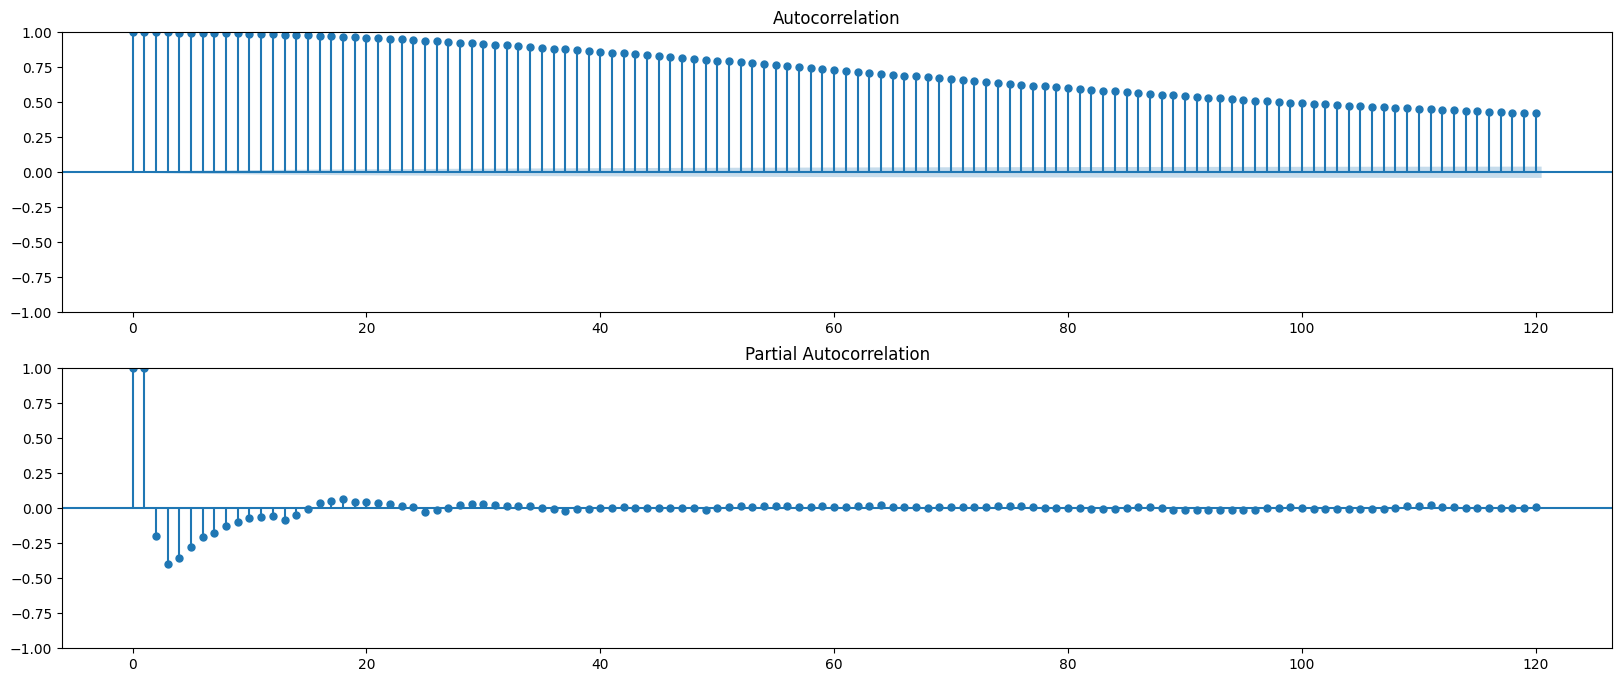

In [16]:
# Running the partial autocorrelation and partial autocorrelation plots
func_plot(data['Load'])

### SARIMAX model
The first SARIMAX model is run using a naive approach with just one autoregressive (AR) and one Moving Average (MA) component. Since using 8,760 periods (i.e. the number of hours in a given year that is not a leap year) are computationally intensive, I limit those to 24 periods.

But before running the model, I make some adjustments to the database so we can account for the exogenous variables as well. The model takes around 20 min to run using a Macbook Air (M1 Chip). Even though far from being the most rigorous exercise, it provides good results. 

From a high level view, we can check that residuals look very like white noise. At the same time, the correlogram doesn't look like a normal distribution. We can reject the null from the Jarque-Bera statistic at the 1% critical level. This can be easily inspected since its kurtosis is far from being 3, even though the skewness is close to 0. Furthermore, the Ljung-Box statistics provides evidence of autocorrelation - which can be a byproduct of the number of lags.

Lastly, the QQ plot also show some deviations from normality, specially at the extreme lower and upper quantiles. The Mean Absolute Error (MAPE) is extremely low and the fit seems to be visually adherent using a 24 hour (next-day) period using training data.


In [17]:
# Starting with the exogenous
train_exo, test_exo = train[['Time Stamp', 'CTHI', 'CDD', 'HDD', 'Holiday']].set_index('Time Stamp'), \
test[['Time Stamp', 'CTHI', 'CDD', 'HDD', 'Holiday']].set_index('Time Stamp')

# Setting up then Train and Test
train, test = train[['Time Stamp', 'Load']].set_index('Time Stamp'), test[['Time Stamp', 'Load']].set_index('Time Stamp')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                               Load   No. Observations:                71986
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood             -329549.716
Date:                            Wed, 10 May 2023   AIC                         659117.432
Time:                                    10:42:42   BIC                         659200.086
Sample:                                         0   HQIC                        659142.892
                                          - 71986                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CTHI           0.8332      1.042      0.800      0.424      -1.208       2.875
CDD            0.3267      0.689   

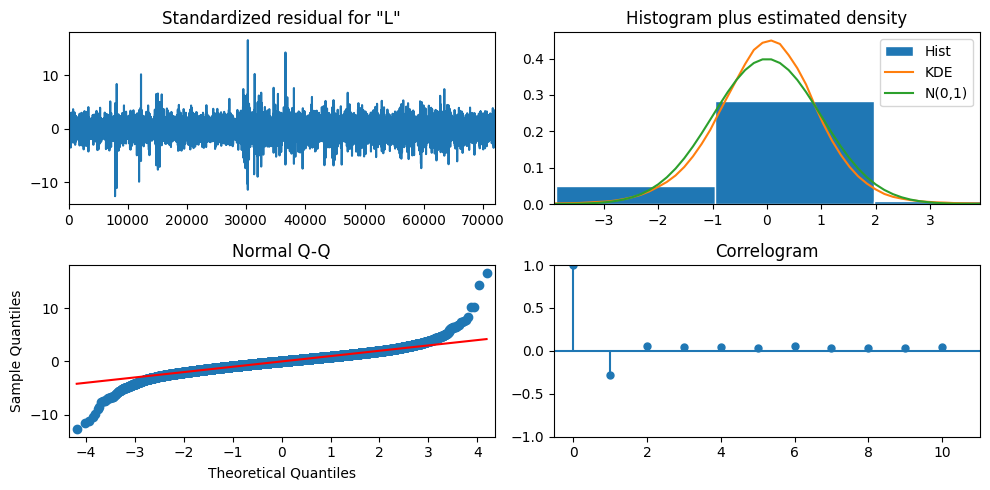

In [18]:
# SARIMAX baseline model
sarimax(train, exog = train_exo, pdq = (1, 1, 1), pdqs = (1, 1, 1, 24), train_test = 'train', window = 24)

### Forecasting with the SARIMAX model
The forecasting process with the SARIMAX model takes around 30 minutes to run. Thus, it is unfeasible to think of tuning it - since with increased complexity, the model is going to take longer. I've been using Google Colab to run this exercise, so to make the most use out of it, I'm going to focus on models that can make greater use of its capabilities, such as the Long Short-Term Memory models (LSTM).

On an overall inspection, we can see the hourly forecast misses the general load shape pattern that is desired, which also shows that it might not be the best option in trying to match the load shapes. The forecasted values hover around zero with quite an amplitude to its confidence interval.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


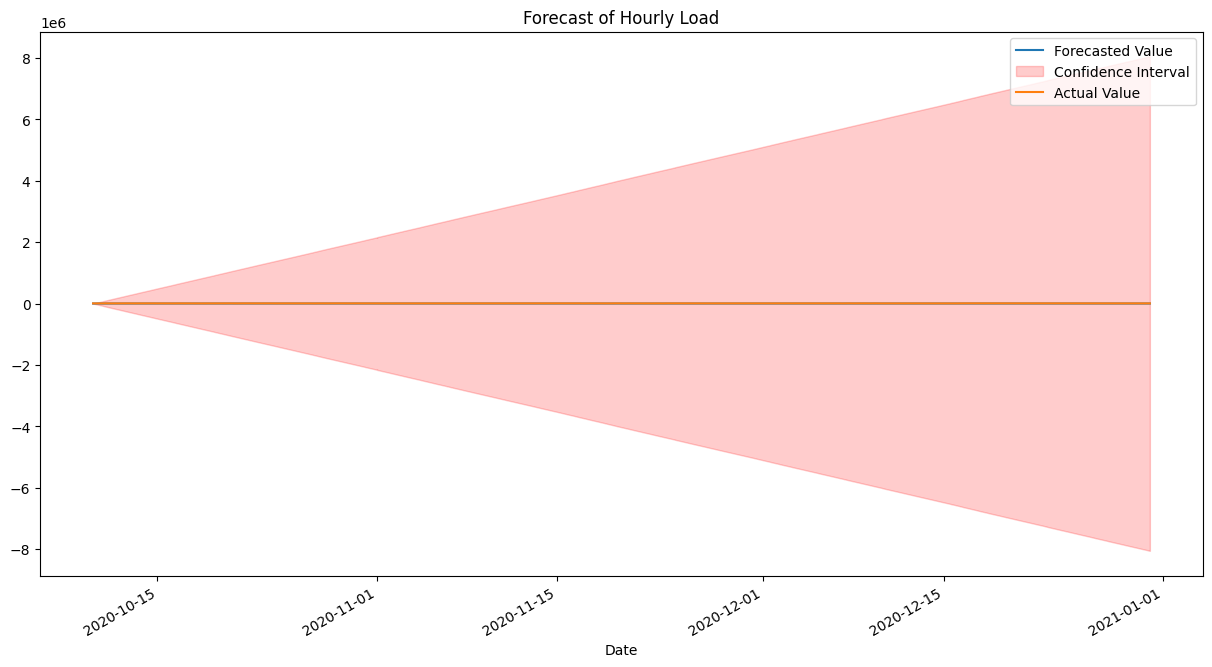

In [19]:
# SARIMAX forecasting
forecast_ci(test, exog = test_exo, pdq = (1, 1, 1), pdqs = (1, 1, 1, 24))

## Neural Networks
This section is dedicated to Neural Networks, more specifically, the Long Short-term Memory is a commonly used in forecasting electricity load, however a few adjusments are made necessary. I start with adjusting the data so we can run our models accordingly. Then I estimate two versions of the LSTM, one that has a simpler construction and another one with several layers and more sophisticated features.

In [20]:

# Setting up the train, test and holdout set
train_set = data.iloc[: int(round(0.5 * len(data), 0))]
test_set =  data.iloc[int(round(0.5 * len(data), 0)) : int(round(0.75 * len(data), 0))]
houldout_set = data.iloc[int(round(0.75 * len(data), 0)) : ]

# Transforming dummies into integers
data.iloc[:, 8:] = data.iloc[:, 8:].astype(int)

# Converting data to LTSM's format
features = list(data.columns)

# Removing junk
features.remove('Time Stamp')
features.remove('Load')

# Getting back to the formatting
target = 'Load'
features_target = features.copy()
features_target.append(target)

# Now, Setting up for keras - Step #1
train_data_keras = train_set[features_target]
test_data_keras = test_set[features_target]

# Running StandardScaler, fitting and transforming
scaler = StandardScaler()
train_data_keras_s = scaler.fit_transform(train_data_keras.values) 
test_data_keras_s = scaler.transform(test_data_keras.values)

# Setting up for keras -  Step #2
X_train_keras = (
    train_data_keras_s[:,:-1].reshape(train_data_keras_s.shape[0],1,len(features))
)
y_train_keras = train_data_keras_s[:,-1]

X_test_keras = (
    test_data_keras_s[:,:-1].
    reshape(test_data_keras_s.shape[0],1,len(features))
)
y_test_keras = test_data_keras_s[:,-1]

# Setting up the neural network model
adam = Adam(lr = 0.001)


### Long Short-Term Memory
I start with a three layer model adding a LSTM, a Dropout and a Dense Layer. The loss function is set to the Mean Absolute Error, whereas the optimizer is set to Adam. The training loss isn't affect much after each epoch run, however we see a difference as epochs increase to the validation set. The model takes around 4 mins to run.

I also set up early stopping, checkpoints and learning rate losses callbacks, so the process stops whenever hitting those targets. After that, I also provide plots with the learning losses from the validation and training set. Lastly I plot the overlap between the data and predicted values.

The mean absolute percent error (MAPE) is pretty decent, hovering around the 10.30% with a not-so-complex neural network model.

In [21]:

# Creating and compiling the NN
model = Sequential()
model.add(LSTM(256, input_shape = (X_train_keras.shape[1], X_train_keras.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss = 'mae', optimizer = adam)

# Callbacks
monitor_param = 'val_loss'
mode = 'min'
early_stopping = EarlyStopping(monitor = monitor_param, patience = 8, verbose = 0, mode = mode)
checkpoint_save = ModelCheckpoint('./single_lstm/checkpoint',save_weights_only = True, monitor = monitor_param, mode = mode)
reduce_lr_loss = ReduceLROnPlateau(monitor =  monitor_param, factor = 0.1, patience = 5, verbose = 0, mode = mode)

# Fitting the model
history = model.fit(X_train_keras, y_train_keras, epochs = 100, batch_size = 30, validation_data = (X_test_keras, y_test_keras), \
                    callbacks = [early_stopping, checkpoint_save, reduce_lr_loss])


Epoch 1/100
5333/5333 [==============================] - 30s 4ms/step - loss: 0.5302 - val_loss: 0.5431 - lr: 0.0010
Epoch 2/100
5333/5333 [==============================] - 22s 4ms/step - loss: 0.5265 - val_loss: 0.5374 - lr: 0.0010
Epoch 3/100
5333/5333 [==============================] - 22s 4ms/step - loss: 0.5258 - val_loss: 0.5407 - lr: 0.0010
Epoch 4/100
5333/5333 [==============================] - 22s 4ms/step - loss: 0.5251 - val_loss: 0.5423 - lr: 0.0010
Epoch 5/100
5333/5333 [==============================] - 22s 4ms/step - loss: 0.5250 - val_loss: 0.5455 - lr: 0.0010
Epoch 6/100
5333/5333 [==============================] - 22s 4ms/step - loss: 0.5247 - val_loss: 0.5447 - lr: 0.0010
Epoch 7/100
5333/5333 [==============================] - 22s 4ms/step - loss: 0.5247 - val_loss: 0.5388 - lr: 0.0010
Epoch 8/100
5333/5333 [==============================] - 22s 4ms/step - loss: 0.5222 - val_loss: 0.5414 - lr: 1.0000e-04
Epoch 9/100
5333/5333 [==============================] - 22s

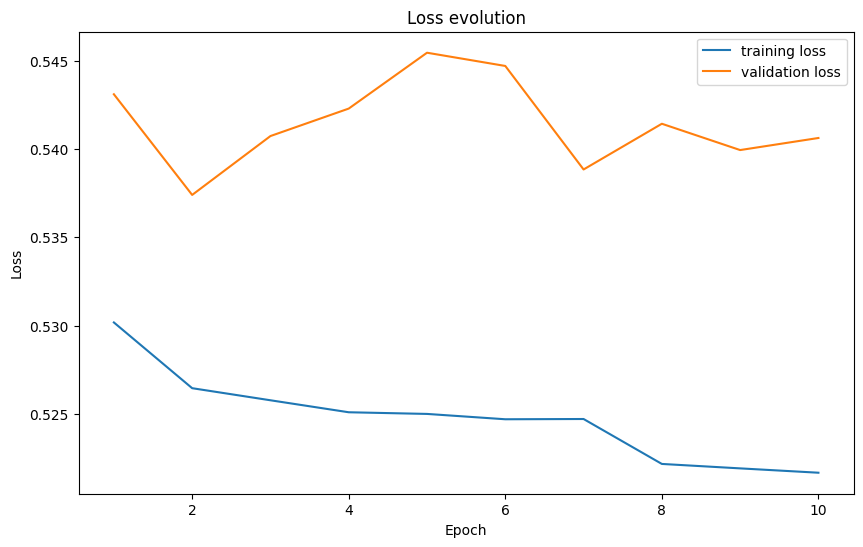

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    range(1, len(history.history["loss"]) + 1),
    history.history["loss"],
    label="training loss",
)
ax.plot(
    range(1, len(history.history["loss"]) + 1),
    history.history["val_loss"],
    label="validation loss",
)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss evolution")
ax.legend(loc="best");

2500/2500 [==============================] - 4s 2ms/step


10.389895734801827

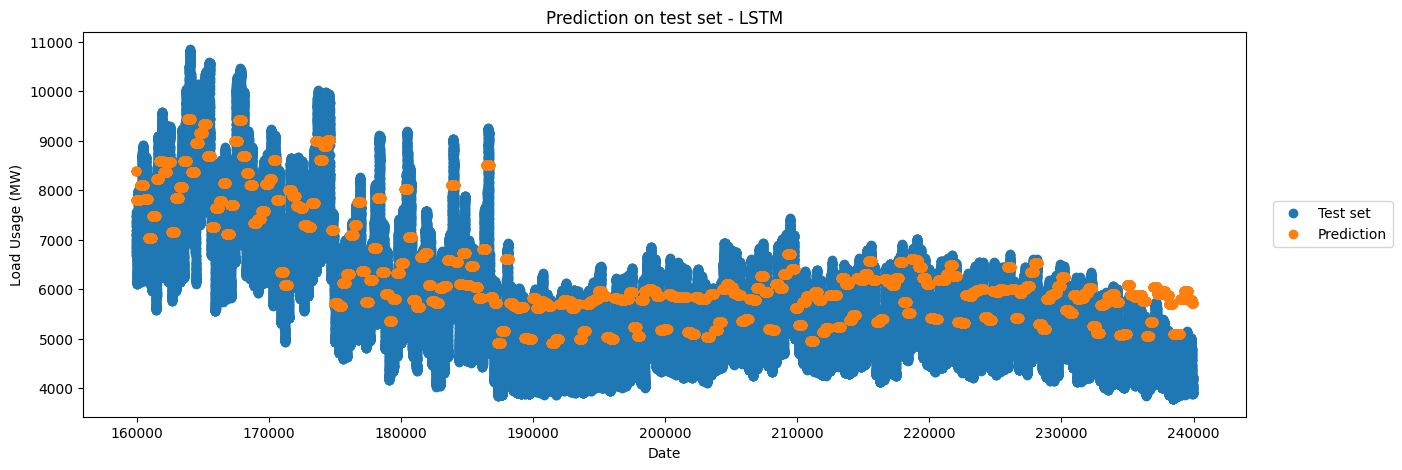

In [23]:
# Using the test set for prediction
pred_lstm = model.predict(X_test_keras)

# Inverse the transform prediction
results_lstm = test_data_keras_s
results_lstm[:,-1] = pred_lstm.reshape(pred_lstm.shape[0])
results_lstm = scaler.inverse_transform(results_lstm)

# Storing inverse transformed
df_results = pd.DataFrame(results_lstm, columns = test_data_keras.columns, index = test_data_keras.index)

# Plotting it
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(test_data_keras.index, test_data_keras['Load'], 'o', label = 'Test set')
ax.plot(test_data_keras.index, df_results['Load'], "o", label = 'Prediction')

ax.legend(loc = "center", bbox_to_anchor = (1.075, 0.5))

ax.set_title("Prediction on test set - LSTM")
ax.set_ylabel("Load Usage (MW)")
ax.set_xlabel("Date");

# MAPE Calculation
mape(df_results['Load'], test_data_keras['Load'])

### Deep LSTM
Next, I try a LSTM NN with three layers, using the Mean Absolute Error as the loss function and ADAM as the optimizer. The Dropout is set to 0.2 on each of the hidden layers. On an overall inspection, we can see that the mean absolute percent error (MAPE) between the test set and the prediction is of 10.40%.

Eyeballing the data, we can see that the general fit is good, however it misses to capture the troughs from the middle of the series onwards.

Following the usual guidelines, since the improvement from this model is negligible compared to the simpler one - it would be advised to stick with the plain vanilla NN.

On a set of unreported results, I've run a GridSearchCV and RandomizedSearchCV to find the best parameters. Using my current specs it is unfeasible to do it. The process took more than 20 hours and errored out at the end.

Of course a less convoluted type of process can be run, at the expense of not finding the best hyperparameter tuning. However, with the current objective of exercising different models to capture the essence of electricity load, these are good starting points.


In [24]:

model = Sequential()
model.add(LSTM(256, input_shape = (X_train_keras.shape[1], X_train_keras.shape[2]), return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss = 'mae', optimizer = adam)

# Callbacks
monitor_param = 'val_loss'
mode = 'min'
early_stopping = EarlyStopping(monitor = monitor_param, patience = 8, verbose = 0, mode = mode)
checkpoint_save = ModelCheckpoint(
    './deep_lstm/checkpoint', save_weights_only = True, monitor = monitor_param, mode = mode)
reduce_lr_loss = ReduceLROnPlateau(monitor=monitor_param, factor=0.1, patience=5, verbose=0, mode=mode)

# Fit model
history_deep_lstm = model.fit(X_train_keras, y_train_keras, epochs = 100, batch_size = 30, 
                              validation_data = (X_test_keras, y_test_keras), 
                              callbacks = [early_stopping, checkpoint_save, reduce_lr_loss])


Epoch 1/100
5333/5333 [==============================] - 41s 7ms/step - loss: 0.5317 - val_loss: 0.0635 - lr: 1.0000e-04
Epoch 2/100
5333/5333 [==============================] - 37s 7ms/step - loss: 0.5270 - val_loss: 0.0403 - lr: 1.0000e-04
Epoch 3/100
5333/5333 [==============================] - 37s 7ms/step - loss: 0.5266 - val_loss: 0.0434 - lr: 1.0000e-04
Epoch 4/100
5333/5333 [==============================] - 36s 7ms/step - loss: 0.5259 - val_loss: 0.0686 - lr: 1.0000e-04
Epoch 5/100
5333/5333 [==============================] - 37s 7ms/step - loss: 0.5259 - val_loss: 0.0701 - lr: 1.0000e-04
Epoch 6/100
5333/5333 [==============================] - 38s 7ms/step - loss: 0.5252 - val_loss: 0.0496 - lr: 1.0000e-04
Epoch 7/100
5333/5333 [==============================] - 39s 7ms/step - loss: 0.5251 - val_loss: 0.0375 - lr: 1.0000e-04
Epoch 8/100
5333/5333 [==============================] - 36s 7ms/step - loss: 0.5249 - val_loss: 0.0726 - lr: 1.0000e-04
Epoch 9/100
5333/5333 [=========

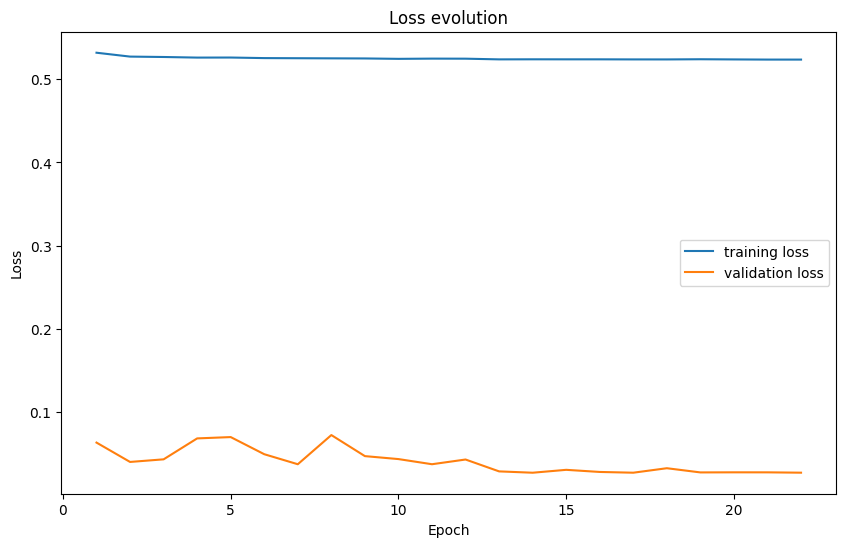

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    range(1, len(history_deep_lstm.history["loss"]) + 1),
    history_deep_lstm.history["loss"],
    label = "training loss",
)
ax.plot(
    range(1, len(history_deep_lstm.history["loss"]) + 1),
    history_deep_lstm.history["val_loss"],
    label = "validation loss",
)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss evolution")
ax.legend(loc="best");

In [26]:
# Prediction on test set
pred_deep_lstm = model.predict(X_test_keras)

# Inverse transform the prediction
# we need to store the prediction in the a copy of the original data
results_deep_lstm = test_data_keras_s
results_deep_lstm[:,-1] = pred_deep_lstm.reshape(pred_deep_lstm.shape[0])
results_deep_lstm = scaler.inverse_transform(results_deep_lstm)

# Store inverse transformed preductons in the result dataframe
# Storing inverse transformed
df_results = pd.DataFrame(results_deep_lstm, columns = test_data_keras.columns, index = test_data_keras.index)

2500/2500 [==============================] - 7s 3ms/step


10.412612949039138

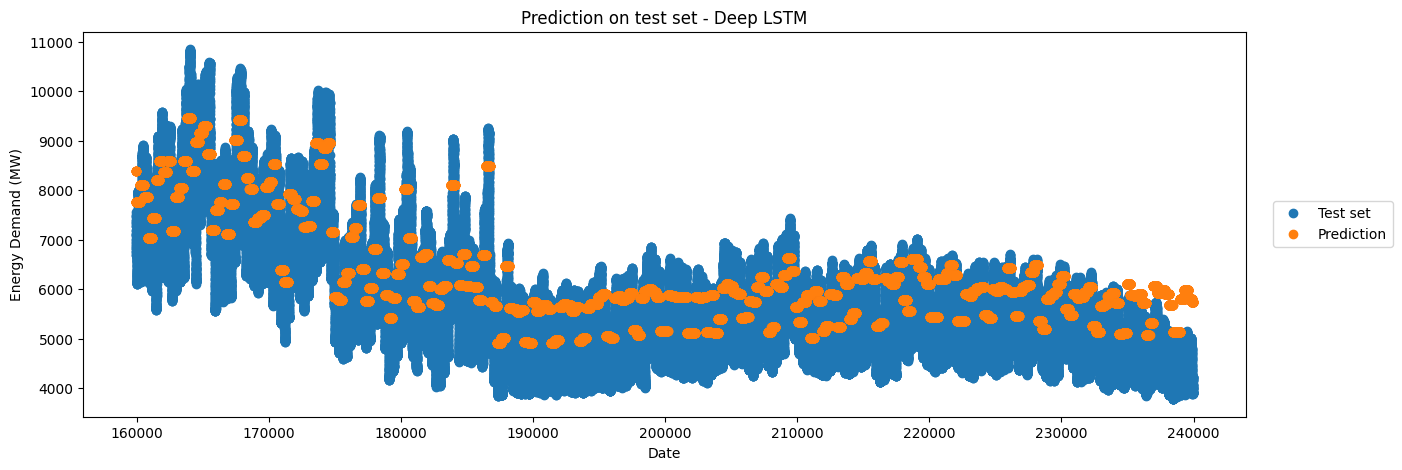

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_data_keras.index, test_data_keras['Load'], "o", label = "Test set")
ax.plot(test_data_keras.index, df_results["Load"], "o", label = "Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Deep LSTM")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date")

# MAPE Calculation
mape(df_results['Load'], test_data_keras['Load'])

## The Prophet Model
Next, I try the Facebook Prophet Model. This model has been used by its simplicity and is ability to capture seasonal patterns that might be difficult to model. Furthermore, the model is pretty flexible in providing also alternatives to set up your own seasonality patterns.

I start setting up the model using the Prophet's own format. From there, we follow the standard steps. The first plot shows there are several seasonalities, ranging from weekly, daily and yearly. The model's output also provides a trend inspection.

In [28]:
train = data.iloc[:int(round(len(data) * (1 - split_size), 0))]
test = data.iloc[-int(round(len(data) * split_size, 0)):]

# Setting up the simple datasets
pf_train, pf_test = train[['Time Stamp', 'Load']], test[['Time Stamp', 'Load']]

# Preparing the data for the Prophet Model - train and test
pf_train = pf_train.reset_index().rename(columns={'Time Stamp': 'ds', 'Load': 'y'})
pf_test = pf_test.reset_index().rename(columns={'Time Stamp': 'ds', 'Load': 'y'})

DEBUG:cmdstanpy:input tempfile: /tmp/tmpy76s0mg_/vx2qmmsk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy76s0mg_/x4cgpxf1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9698', 'data', 'file=/tmp/tmpy76s0mg_/vx2qmmsk.json', 'init=/tmp/tmpy76s0mg_/x4cgpxf1.json', 'output', 'file=/tmp/tmpy76s0mg_/prophet_models41d5g_p/prophet_model-20230510111137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:11:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:15:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


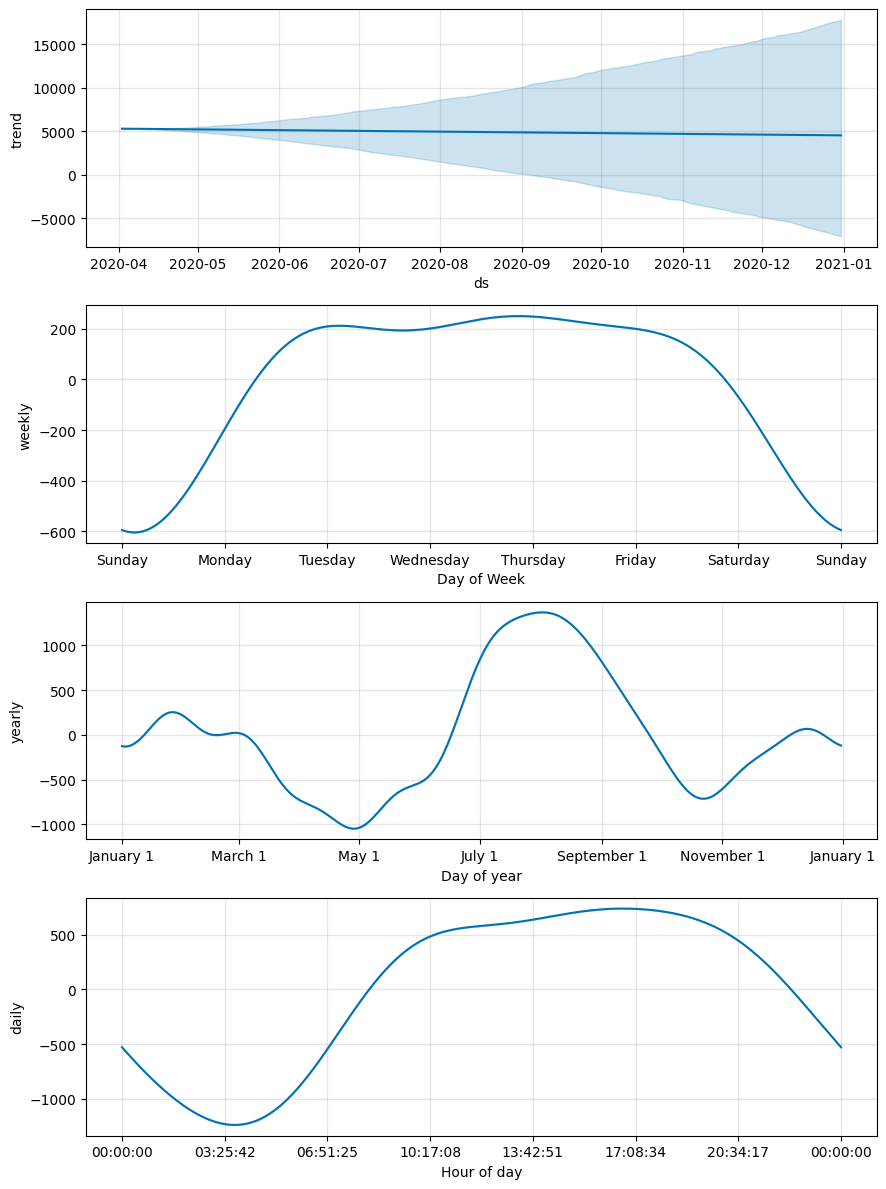

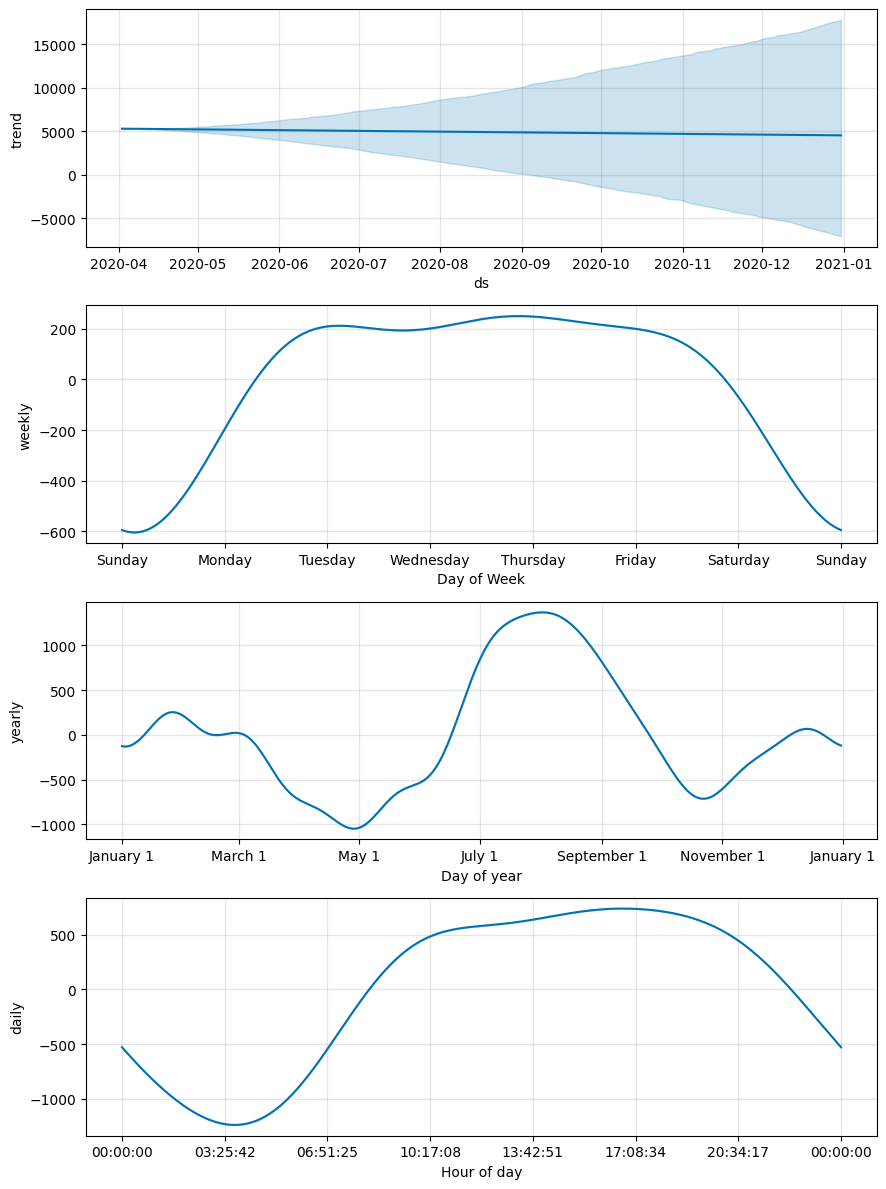

In [29]:
# Instantiating and Fitting the Prophet Model
prophet = Prophet()
prophet.fit(pf_train)

# Generating the prediction DataFrame using test data
pr_pred_df = prophet.predict(pf_test)

# Plotting Prophet Model components
prophet.plot_components(pr_pred_df)


### Prophet Prediction
The prediction using the test set captures the overall shape of the hourly load. By eyeballing the data it is possible to see as the periods start to increase, the overall forecasting uncertainty also increases.

Even though having a good 'look', it's mape is less than satisfactory. The comparison between the prediction and the test data yields a mean absolute percent error of 44%.

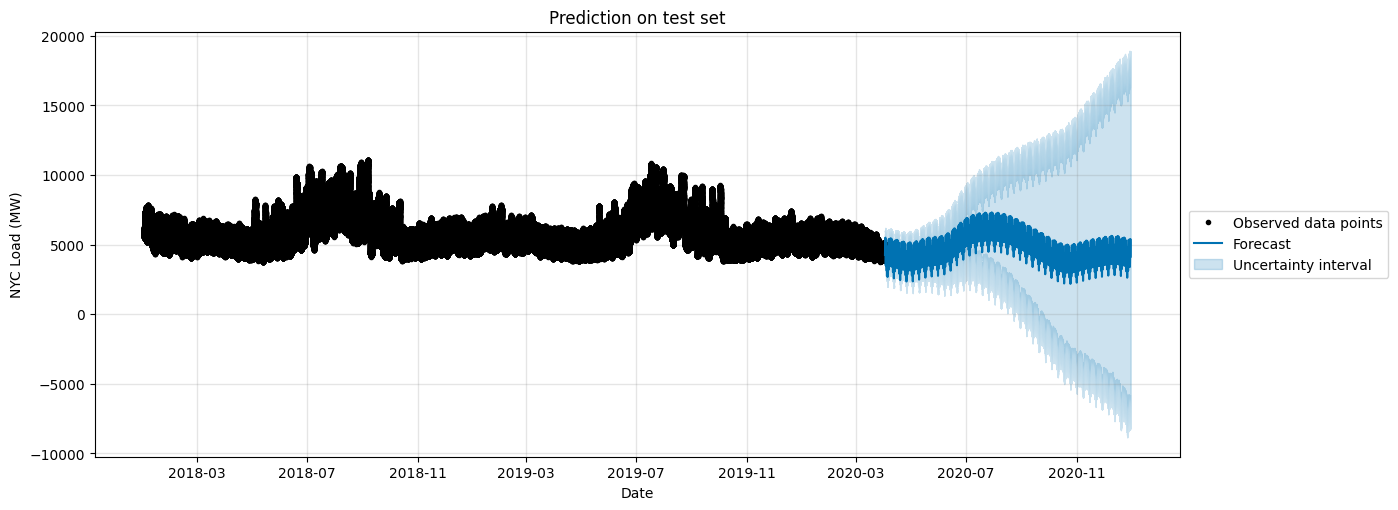

In [30]:
# Plotting the prediction using the test set
fig, ax = plt.subplots(figsize=(12, 5))

prophet.plot(pr_pred_df, ax = ax, include_legend = True)
ax.legend(bbox_to_anchor = (1.1, 0.5), loc = 'center', ncol=1)

ax.set_title('Prediction on test set')
ax.set_ylabel("NYC Load (MW)")
ax.set_xlabel("Date");

In [31]:
mape(pr_pred_df['yhat'], train['Load'])

44.2308524025178

### Prophet, second run
Next, I run a version of the Prophet adding the exogenous variables from previous models. As usual, the seasonality plot shows how the addition of these regressors are affecting the load shapes. We can also check the other seasonality features from the first model.

We can see how the MAPE gets better just by adding the exogenous variables. Also, the overal looks of the series seem more inline with the general pattern that we've been seeing and the uncertainty interval gets less wide.

I also provide another plot that shows how the prediction is almost matching the test dataset, however as time evolves it starts to deviate considerably.

DEBUG:cmdstanpy:input tempfile: /tmp/tmpy76s0mg_/hd6v9irb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy76s0mg_/1dk66t2r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62504', 'data', 'file=/tmp/tmpy76s0mg_/hd6v9irb.json', 'init=/tmp/tmpy76s0mg_/1dk66t2r.json', 'output', 'file=/tmp/tmpy76s0mg_/prophet_modelgoq39xsg/prophet_model-20230510111637.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:16:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:22:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


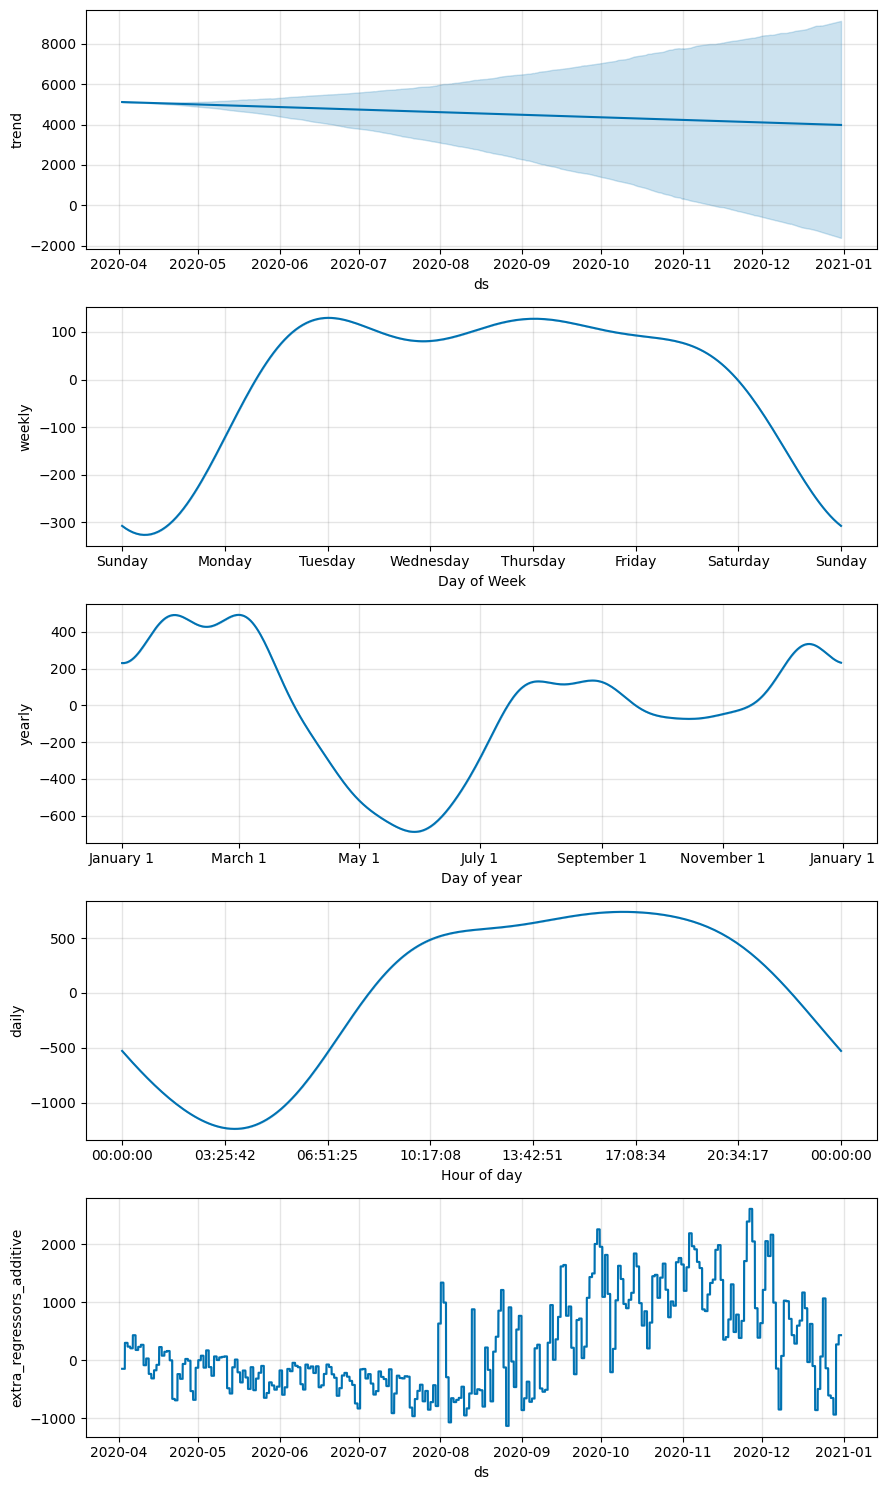

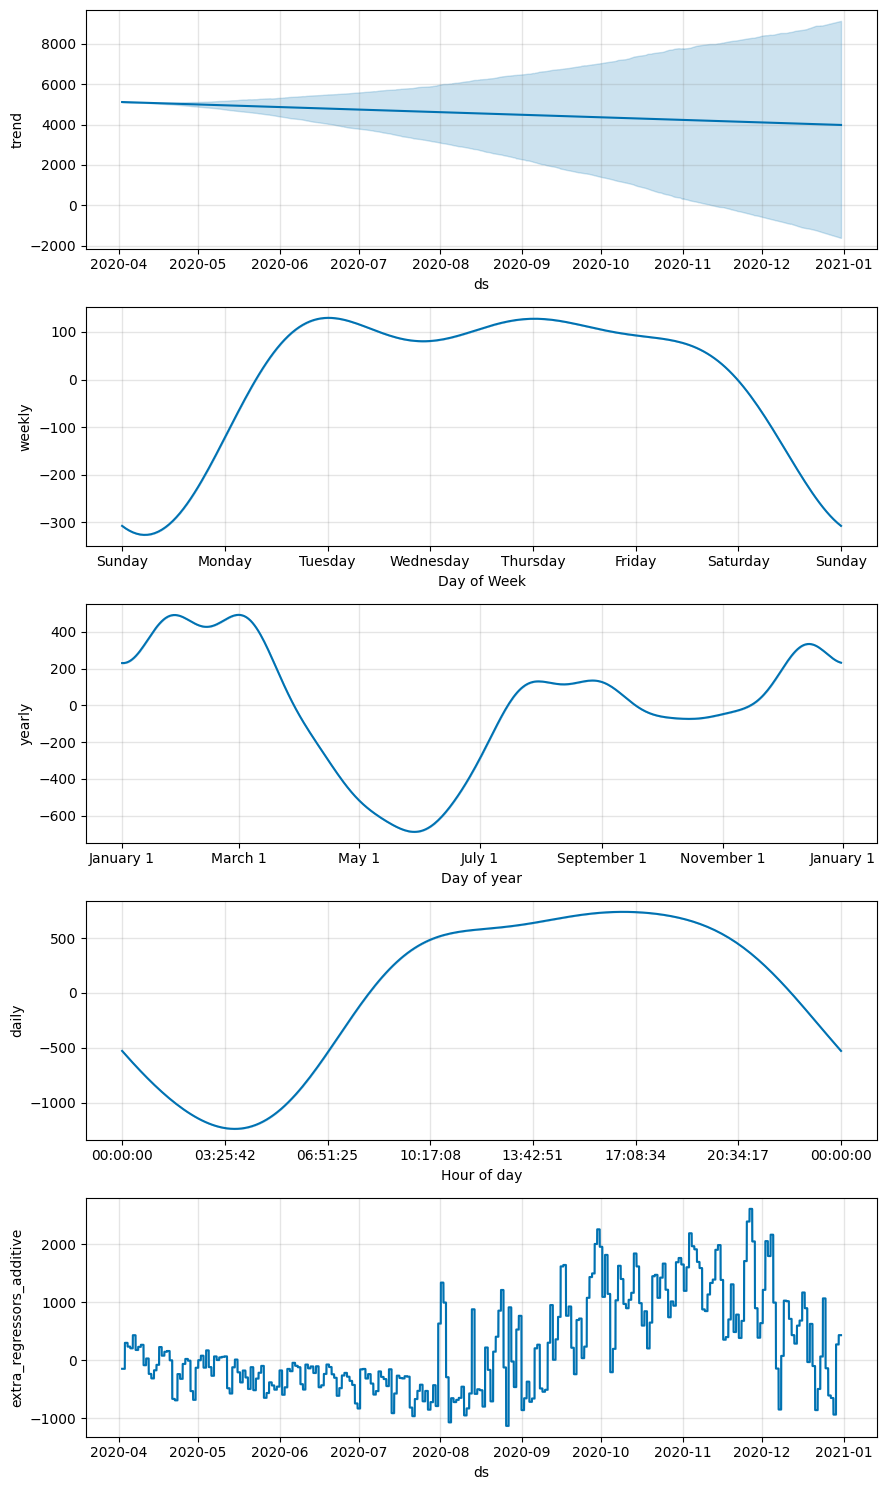

In [32]:
# Joining DataFrames with Exogenous Regressors
# Train
pf_train_exo = data.loc[pf_train.reset_index().index, ['CTHI', 'CDD', 'HDD', 'Holiday', 'OPK', 'Peak']]
pf_train = pf_train.join(pf_train_exo, how = 'inner')

# Test
pf_test_exo = data.loc[pf_test.reset_index().index, ['CTHI', 'CDD', 'HDD', 'Holiday', 'OPK', 'Peak']]
pf_test = pf_test.join(pf_test_exo, how = 'inner')


# Initializing a new Prophet run with seasonalities
model = Prophet()

# Adding Exogenous regressors
model.add_regressor('CTHI')
model.add_regressor('CDD')
model.add_regressor('HDD')
model.add_regressor('Holiday')
model.add_regressor('OPK')
model.add_regressor('Peak')

# Fitting the model
model.fit(pf_train)

# Predicting
pf_pred_df = model.predict(pf_test)

# Future DF
future_df = model.make_future_dataframe(periods = len(pf_test))

# Plotting Prophet Model components
model.plot_components(pf_pred_df)


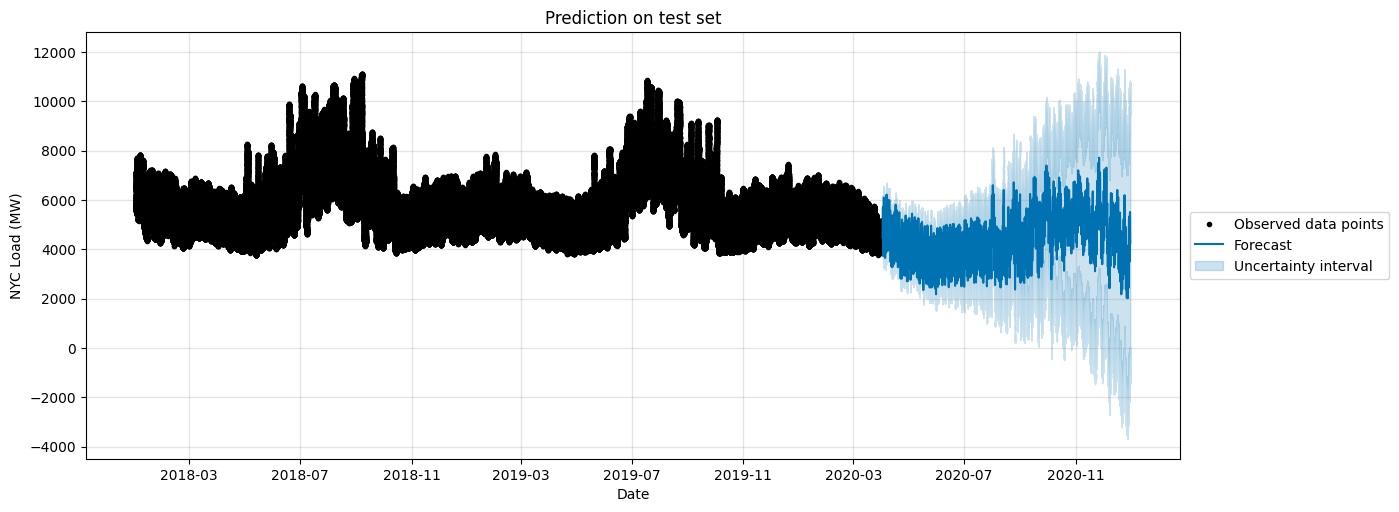

In [33]:
# Plotting the prediction using the test set
fig, ax = plt.subplots(figsize=(12, 5))

model.plot(pf_pred_df, ax = ax, include_legend = True)
ax.legend(bbox_to_anchor = (1.1, 0.5), loc = 'center', ncol=1)

ax.set_title('Prediction on test set')
ax.set_ylabel("NYC Load (MW)")
ax.set_xlabel("Date");

In [34]:
mape(pf_pred_df['yhat'], pf_test['y'])

31.266057323044787

## Recommendation
In this project, I presented three frameworks with the aim of providing a time series approach to minimize hourly load forecasting mismatch.

The steps pursued are: data preparation and analysis, model creation, modeling alternatis with fine tuning and discussions. Unfortunately, data and computational limitations are a point to be addressed. Specifically, by adding hourly weather data, as well as other socio-economic and power specific information the results can be more precise. Furthermore, since most of these tools require significant processing power, the use of robust resources will not only speed up the process, but also provide new venues to be explored.

With those comments out of the way, one could recommend the following strategies:
<ul>
<li><b>Peak Forecasting:</b> the LSTM model is pretty good in capturing the load shapes when there are peaks. It doesn't capture the troughs as well, so one could use it to forecast from June through August using the simple LSTM;</li>
<li><b>Off-Peak Forecasting:</b> generally the Prophet does a good job in capturing the load shapes in general and has a good fit when load is decreasing.So using it from June through May and then September through December might be a good idea;</li>
<li><b>Ensemble models:</b>the best recommendation would be trying ensemble models that would combine the best of both worlds. Since this is beyond the scope of this exercise, that is one idea to be thought off.</li>
</ul>

### Limitations
The limitations are mostly data related and computational power related. Having more granular temperature data and adding some other features such as generation and transmission data most likely will enhance the assertiveness of the model. Furthermore, having more computational power will allow for more hyperparameter tuning and also quicker model runs.

## Appendix: Randomized Search

Now, I perform a randomized search with cross validation to tune the hyperparameters. As discussed previously, given the computational limitations, I only perform a few combinations.

With more processing power one could also combine more hyperparameters and even combine the randomized search with grid search. Lastly, even though promising, this exercise didn't provide great changes to the overall MAPE, when compared to our simple LSTM model.

In [35]:

# Define the hyperparameters to search over
params = {
    'optimizer': ['adam'],
    'neurons': randint(64, 256),
    'dropout': uniform(0.1, 0.4),
    'learning_rate': uniform(0.0001, 0.05),
    'batch_size': randint(16, 128)
}

# Create the KerasRegressor object with the create_model function
model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=30, verbose=0)

# Use RandomizedSearchCV to perform the randomized search
search = RandomizedSearchCV(model, param_distributions=params, n_iter=10, cv=3, n_jobs=-1, random_state=42)

# Callbacks
monitor_param = 'val_loss'
mode = 'min'
early_stopping = EarlyStopping(monitor = monitor_param, patience = 8, verbose = 0, mode = mode)
checkpoint_save = ModelCheckpoint('./search_lstm/checkpoint',save_weights_only = True, monitor = monitor_param, mode = mode)
reduce_lr_loss = ReduceLROnPlateau(monitor =  monitor_param, factor = 0.1, patience = 5, verbose = 0, mode = mode)

search_result = search.fit(X_train_keras, y_train_keras, validation_data=(X_test_keras, y_test_keras), \
                    callbacks=[early_stopping, checkpoint_save, reduce_lr_loss])

# Print the best parameters and score
print("Best parameters:", search_result.best_params_)
print("Best score:", search_result.best_score_)


Best parameters: {'batch_size': 91, 'dropout': 0.3446612641953124, 'learning_rate': 0.0004533152609858703, 'neurons': 152, 'optimizer': 'adam'}
Best score: -0.5504769682884216


In [36]:
# Setting up the neural network model
adam = Adam(lr = 0.0004533152609858703)

# Creating and compiling the NN
model = Sequential()
model.add(LSTM(152, input_shape = (X_train_keras.shape[1], X_train_keras.shape[2])))
model.add(Dropout(0.3446612641953124))
model.add(Dense(1))
model.compile(loss = 'mae', optimizer = adam)

# Callbacks
monitor_param = 'val_loss'
mode = 'min'
early_stopping = EarlyStopping(monitor = monitor_param, patience = 8, verbose = 0, mode = mode)
checkpoint_save = ModelCheckpoint('./search_lstm/checkpoint',save_weights_only = True, monitor = monitor_param, mode = mode)
reduce_lr_loss = ReduceLROnPlateau(monitor =  monitor_param, factor = 0.1, patience = 5, verbose = 0, mode = mode)

# Fitting the model
history = model.fit(X_train_keras, y_train_keras, epochs = 100, batch_size = 91, validation_data = (X_test_keras, y_test_keras), \
                    callbacks = [early_stopping, checkpoint_save, reduce_lr_loss])


Epoch 1/100
1758/1758 [==============================] - 9s 5ms/step - loss: 0.5373 - val_loss: 0.0610 - lr: 4.5332e-04
Epoch 2/100
1758/1758 [==============================] - 7s 4ms/step - loss: 0.5271 - val_loss: 0.0439 - lr: 4.5332e-04
Epoch 3/100
1758/1758 [==============================] - 8s 5ms/step - loss: 0.5257 - val_loss: 0.0382 - lr: 4.5332e-04
Epoch 4/100
1758/1758 [==============================] - 8s 4ms/step - loss: 0.5253 - val_loss: 0.0512 - lr: 4.5332e-04
Epoch 5/100
1758/1758 [==============================] - 7s 4ms/step - loss: 0.5247 - val_loss: 0.0319 - lr: 4.5332e-04
Epoch 6/100
1758/1758 [==============================] - 8s 4ms/step - loss: 0.5251 - val_loss: 0.0353 - lr: 4.5332e-04
Epoch 7/100
1758/1758 [==============================] - 8s 4ms/step - loss: 0.5242 - val_loss: 0.0440 - lr: 4.5332e-04
Epoch 8/100
1758/1758 [==============================] - 8s 4ms/step - loss: 0.5241 - val_loss: 0.0630 - lr: 4.5332e-04
Epoch 9/100
1758/1758 [=================

In [37]:
# Prediction on test set
search_lstm = model.predict(X_test_keras)

# Inverse transform the prediction
# we need to store the prediction in the a copy of the original data
results_search_lstm = test_data_keras_s
results_search_lstm[:,-1] = search_lstm.reshape(search_lstm.shape[0])
results_search_lstm = scaler.inverse_transform(results_search_lstm)

# Store inverse transformed preductons in the result dataframe
# Storing inverse transformed
df_results = pd.DataFrame(results_search_lstm, columns = test_data_keras.columns, index = test_data_keras.index)

# MAPE Calculation
mape(df_results['Load'], test_data_keras['Load'])

2500/2500 [==============================] - 4s 2ms/step


10.405449274638228